# 2021-08-31 Implementing support for acceleration-aware value estimation

Results below are for commit: 

(Rerunning the code below for other commits is not guaranteed to give the same results)

---

Previously, the "access order implications", i.e., the calculations of the needed accelerations for an agent to pass either before or after another agent, were calculated based just observing the position and speed of the other agent. As noted in previous diary entries, this seems insufficient to get good behaviour from agents that infer the behaviour of others. Therefore I have now modified the implementation so that the access order accelerations are calculated based on observation also of the acceleration of the other agent. To make this easier to implement I have removed the possibility for pedestrian agents to reverse (previously this possibility was removed only for vehicle agents) - this doesn't seem like a major limitation for the present purposes, and reduces the number of possible cases that need to be considered in the calculations. 

More specifically, I have:

* Removed support for reversing in `SCAgent`, regardless of agent type.
* Removed possibility of reversing in order to pass in second in `sc_scenario_helper.get_access_order_implications()`:
* Reimplemented `sc_scenario_helper.get_entry_exit_times()`.
* Extended the unit tests in `sc_scenario_helper` with some non-constant-speed ones, and verified that the stuff I did above seems to work ok.

## Init    

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:87: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Unit tests, reproducing earlier results

Just the base model, no interaction

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


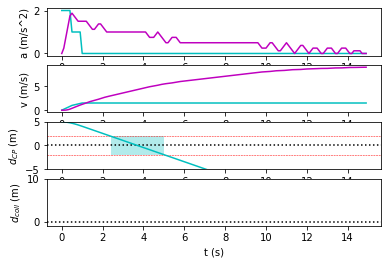

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = False)

Baseline kinematics, base model. It wasn't actually obvious at all that this one should come back the same, since the value functions depend on the access order implications calculations. But it does. More likely than not, there are some initial situations which will not give the same results now as before.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


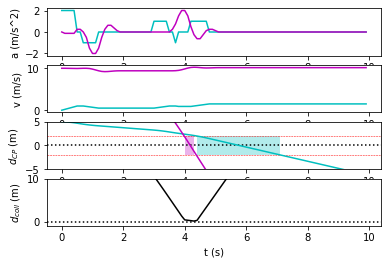

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            ped_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, None))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs)

run_baseline_kinematics(dist0s = (40,))

## Enabling `oBEo`

Turning on `oBEo` we see however, that there still seems to be something wrong about this. Check the middle centre plot in the snapshot below, showing that the pedestrian judges that the car will need to accelerate by 18.62 m/s^2 to pass in front, from the currently predicted no-action state of the pedestrian. My calculations by hand for the same situation suggest that the correct value should be just over 5 m/s^2. So I need to look into this further...

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


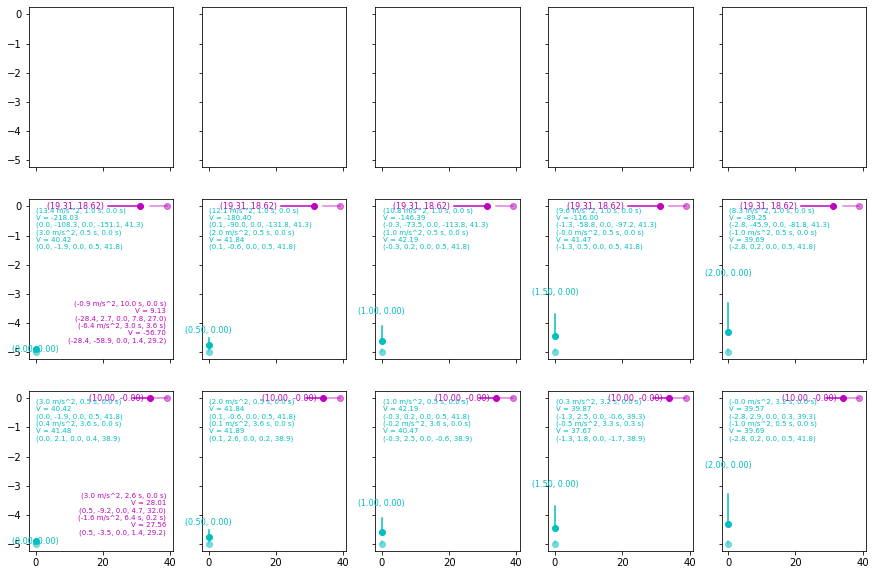

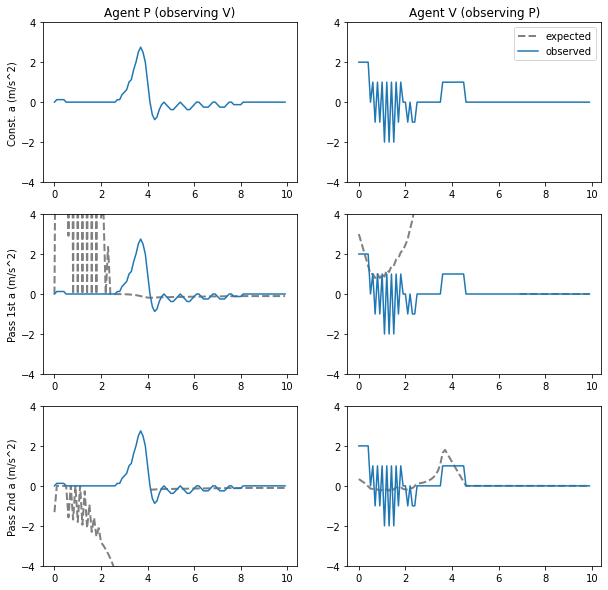

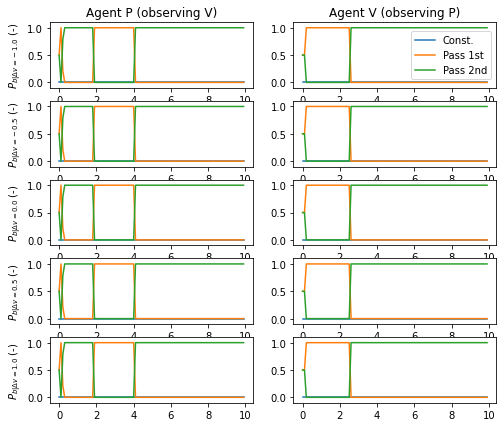

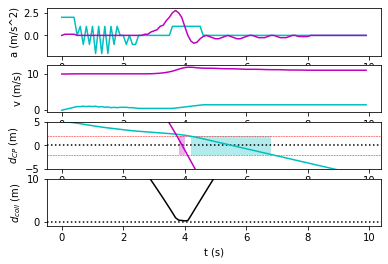

In [4]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True)

run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_accs = True, ped_snaps = (0.1,))